In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# !ln -s /home/ubuntu/fastai/fastai .

In [3]:
from fastai.learner import *

import torchtext
from torchtext import vocab, data
from torchtext.datasets import language_modeling

from fastai.rnn_reg import *
# from fastai.rnn_train import *
from fastai.nlp import *
# from fastai.lm_rnn import *

import dill as pickle
import io



    Only loading the 'en' tokenizer.



In [4]:
SEED = 123456

In [5]:
PATH = 'data'

In [6]:
!ls {PATH}

imdb		       test	      tmp	      trn
models		       test.csv       train.csv       val
sample_submission.csv  test_proc.csv  train_proc.csv  val_proc.csv


## Process training data

In [7]:
txt = pd.read_csv(f'{PATH}/train.csv')
txt.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [8]:
txt.shape

(19579, 3)

In [9]:
txt['author'].value_counts(normalize=True)

EAP    0.403494
MWS    0.308698
HPL    0.287808
Name: author, dtype: float64

In [10]:
# Tokenize to count words
txt['text_toks'] = txt['text'].apply(spacy_tok)
txt['text_len'] = txt['text_toks'].str.len()

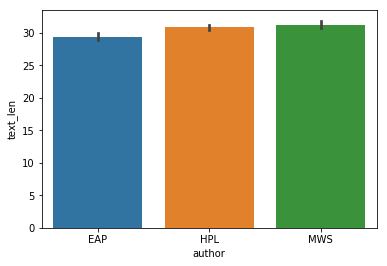

In [11]:
sns.barplot(x='author', y='text_len', data=txt)

In [12]:
txt['text_len'].describe()

count    19579.000000
mean        30.399203
std         20.947826
min          4.000000
25%         17.000000
50%         26.000000
75%         39.000000
max        876.000000
Name: text_len, dtype: float64

In [13]:
# Split into training and test set
txt_trn, txt_val, txt_trn_y, txt_val_y = train_test_split(txt[['id', 'text']], txt['author'], random_state=SEED)

In [14]:
txt_trn.shape, txt_val.shape

((14684, 2), (4895, 2))

In [15]:
# Read in test data
txt_test = pd.read_csv(f'{PATH}/test.csv')
txt_test.head()

,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."
2,id00134,And when they had broken down the frail door t...
3,id27757,While I was thinking how I should possibly man...
4,id04081,I am not sure to what limit his knowledge may ...


In [152]:
# Sort by len
# Because that's how torchtext would sort it,
# I need to do the same thing in order to match its results
txt_test['text_toks'] = txt_test['text'].apply(spacy_tok)
txt_test['text_len'] = txt_test['text_toks'].str.len()
txt_test['index'] = txt_test.index

txt_test.sort_values(by=['text_len', 'index'], inplace=True)
txt_test.reset_index(drop=True, inplace=True)

## Create a language model

In [16]:
# Create a torchtext field
TEXT = data.Field(lower=True, tokenize=spacy_tok, eos_token='<eos>')

In [17]:
bs = 64  # Batch size
bptt = 30  # Number of tokens to process at a time

In [19]:
# Create language model data
txt_lmd = LanguageModelData.from_dataframes(
    path=PATH,
    field=TEXT,
    col='text',
    train_df=txt_trn,
    val_df=txt_val,
    test_df=txt_test,
    bs=bs,
    bptt=bptt,
    min_freq=10)
txt_lmd

In [38]:
# Number of sentences
txt_lmd.trn_dl.n, txt_lmd.val_dl.n, txt_lmd.test_dl.n

(6952, 2347, 3944)

In [21]:
# Vocabulary size
len(TEXT.vocab), txt_lmd.nt

(3960, 3960)

In [22]:
# Vocabulary dict
# Most frequent words
TEXT.vocab.itos[:10]

['<unk>', '<pad>', '<eos>', ',', 'the', 'of', '.', 'and', 'to', 'i']

In [23]:
# Least frequent words
TEXT.vocab.itos[-10:]

['villain',
 'vividly',
 'vulgar',
 'w.',
 'walks',
 'weeds',
 'whispers',
 'wing',
 'worship',
 'writer']

In [24]:
# Word to index
[TEXT.vocab.stoi[s] for s in TEXT.vocab.itos[:10]]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [26]:
# Total number of tokens in the training and validation set
len(txt_lmd.trn_ds[0].text), len(txt_lmd.val_ds[0].text)

(444937, 150251)

In [27]:
# Check out the first sentence in the training set
txt_lmd.trn_ds[0].text[:20]

['one',
 'night',
 ',',
 'near',
 'the',
 'closing',
 'in',
 'of',
 'september',
 ',',
 'she',
 'pressed',
 'this',
 'distressing',
 'subject',
 'with',
 'more',
 'than',
 'usual',
 'emphasis']

In [28]:
# Compare with the training data
txt_trn.iloc[0].text

'One night, near the closing in of September, she pressed this distressing subject with more than usual emphasis upon my attention.'

In [29]:
# Number of batches in the training data
len(txt_lmd.trn_dl), len(txt_lmd.trn_ds[0].text) / bs / bptt

(230, 231.73802083333334)

In [30]:
# Check out a batch
X, y = next(iter(txt_lmd.trn_dl))

In [31]:
X

Variable containing:
   44    11     0  ...     34  2728     4
  107     4     0  ...     83   418   542
    3  3276     7  ...      3     6     6
       ...          ⋱          ...       
   48     0    25  ...     11     3     7
   14    10    13  ...     71    16   109
  352  2133    64  ...      3     9   271
[torch.cuda.LongTensor of size 23x64 (GPU 0)]

In [32]:
y.view(-1, 64)

Variable containing:
  107     4     0  ...     83   418   542
    3  3276     7  ...      3     6     6
  229     5     0  ...      9    33    70
       ...          ⋱          ...       
   14    10    13  ...     71    16   109
  352  2133    64  ...      3     9   271
    6     0   189  ...     64    37    33
[torch.cuda.LongTensor of size 23x64 (GPU 0)]

In [33]:
os.makedirs(f'{PATH}/models', exist_ok=True)
pickle.dump(TEXT, open(f'{PATH}/models/TEXT.pkl','wb'))

## Train the language model

In [18]:
embedding_size = 200
hidden_size = 500
n_layers = 3
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [41]:
learner = txt_lmd.get_model(
    opt_fn=opt_fn,
    emb_sz=embedding_size,
    n_hid=hidden_size,
    n_layers=n_layers,
    dropouti=0.05,
    dropout=0.05,
    wdrop=0.1,
    dropoute=0.02,
    dropouth=0.05)

In [42]:
# Add regularization
learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)

In [43]:
# Gradient clipping
learner.clip = 0.3

In [44]:
# Check out model structure
learner

SequentialRNN (
  (0): RNN_Encoder (
    (encoder): Embedding(3960, 200, padding_idx=1)
    (rnns): ModuleList (
      (0): WeightDrop (
        (module): LSTM(200, 500, dropout=0.05)
      )
      (1): WeightDrop (
        (module): LSTM(500, 500, dropout=0.05)
      )
      (2): WeightDrop (
        (module): LSTM(500, 200, dropout=0.05)
      )
    )
    (dropouti): LockedDropout (
    )
    (dropouth): LockedDropout (
    )
  )
  (1): LinearDecoder (
    (decoder): Linear (200 -> 3960)
    (dropout): LockedDropout (
    )
  )
)

In [98]:
# Find learning rate
learner.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 87%|████████▋ | 201/230 [00:14<00:02, 14.04it/s, loss=25]  

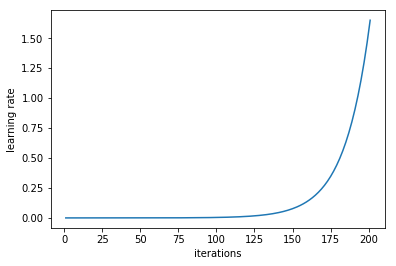

In [99]:
learner.sched.plot_lr()

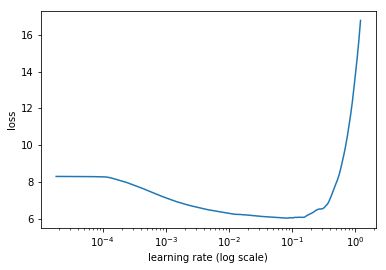

In [100]:
learner.sched.plot()

In [45]:
learning_rate = 0.001

In [46]:
learner.fit(lrs=learning_rate, n_cycle=4, wds=1e-6, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       5.4943   5.41268]                                
[ 1.       5.18617  5.07068]                                
[ 2.       5.04673  4.98784]                                
[ 3.       4.93937  4.8405 ]                                
[ 4.       4.8292   4.75386]                                
[ 5.       4.7635   4.70632]                                
[ 6.       4.73625  4.69409]                                
[ 7.       4.72815  4.6471 ]                                
[ 8.       4.63929  4.59031]                                
[ 9.       4.57225  4.53499]                                
[ 10.        4.50904   4.50774]                             
[ 11.        4.46455   4.48345]                             
[ 12.        4.42123   4.46476]                             
[ 13.        4.39759   4.45931]                             
[ 14.        4.38875   4.45923]                             



In [47]:
# Save the model
learner.save('txt_lm')

# Save the encoder
learner.save_encoder('txt_lm_encoder')

## Test the language model

In [48]:
def sample_model(model, seed_str, output_len=50):
    # Process the seed string
    seed_str_toks = TEXT.preprocess(TEXT.tokenize(seed_str))
    seed_str_toks_num = TEXT.numericalize([seed_str_toks])

    # Set batch size to 1
    model[0].bs = 1

    # Turn off dropoff (eval mode)
    model.eval()

    # Reset hidden states
    model.reset()

    # Generate initial predictions
    pred, *_ = model(seed_str_toks_num)
    print('...', end='')

    for i in range(output_len):
        # Get the last predictions
        pred_last = pred[-1]
        
        # Compute probabilities using softmax
        pred_last_prob = pred[-1].exp() / pred[-1].exp().sum()
        
        # Randomly sample one word per the probabilities
        pred_last_choice = torch.multinomial(pred_last_prob, 1)
        
        # Convert it to word
        word = TEXT.vocab.itos[pred_last_choice.data[0]]
        print(word, end=' ')

        if word == '<eos>':
            break

        # Generate the next predictions
        pred, *_ = model(pred_last_choice.unsqueeze(0))
    
    # Reset encoder batch size
    model[0].bs = bs

In [49]:
print(txt_val['text'].iloc[0])
print(sample_model(learner.model, txt_val['text'].iloc[0]))

The fury of a demon instantly possessed me.
...but at the last days of described some house it is common and so too seen i had felt the walls of the through the marie balloon a greater itself . the <unk> he had seemed for the <unk> , my else near the practice was some <unk> thing . None


## Prepare data for classifications

In [19]:
TEXT = pickle.load(open(f'{PATH}/models/TEXT.pkl','rb'))
LABEL = data.Field(sequential=False)

In [ ]:
# Save processed training, validation, and test data
txt_trn.join(txt_trn_y)[['text', 'author']].to_csv(
    f'{PATH}/train_proc.csv', index=False, header=False)
txt_val.join(txt_val_y)[['text', 'author']].to_csv(
    f'{PATH}/val_proc.csv', index=False, header=False)

In [58]:
txt_test_proc = txt_test[['text']].copy()
txt_test_proc['author'] = np.nan  # Dummy label (hacky)

# Repeat the last row so the real data won't be truncated (very hacky)
txt_test_proc = txt_test_proc.append(txt_test_proc.iloc[[-1] * bs])
txt_test_proc.reset_index(drop=True, inplace=True)
txt_test_proc.to_csv(f'{PATH}/test_proc.csv', index=False, header=False)

In [60]:
# https://github.com/pytorch/text/blob/master/torchtext/data/dataset.py
class TabularDataset(data.Dataset):
    """Defines a Dataset of columns stored in CSV, TSV, or JSON format."""

    def __init__(self, path, format, fields, skip_header=False, **kwargs):
        make_example = {
            'json': data.Example.fromJSON, 'dict': data.Example.fromdict,
            'tsv': data.Example.fromTSV, 'csv': data.Example.fromCSV}[format.lower()]

        with io.open(os.path.expanduser(path), encoding="utf8") as f:
            if skip_header:
                next(f)
            examples = [make_example(line, fields) for line in f]

        if make_example in (data.Example.fromdict, data.Example.fromJSON):
            fields, field_dict = [], fields
            for field in field_dict.values():
                if isinstance(field, list):
                    fields.extend(field)
                else:
                    fields.append(field)

        super(TabularDataset, self).__init__(examples, fields, **kwargs)
    
    @staticmethod
    def sort_key(ex):
        return len(ex.text)

In [61]:
# Create splits
# https://github.com/pytorch/text
txt_splits_trn, txt_splits_val, txt_splits_test = TabularDataset.splits(
    path=PATH,
    train='train_proc.csv',
    validation='val_proc.csv',
    test='test_proc.csv',
    format='csv',
    fields=[('text', TEXT), ('label', LABEL)])

In [88]:
# https://github.com/fastai/fastai/blob/master/fastai/nlp.py
class TextDataWithTest(ModelData):
    def create_td(self, it):
        return TextDataLoader(it, self.text_fld, self.label_fld)

    @classmethod
    def from_splits(cls,
                    path,
                    splits,
                    bs,
                    text_name='text',
                    label_name='label',
                    id_name='id'):
        text_fld = splits[0].fields[text_name]
        label_fld = splits[0].fields[label_name]
        label_fld.build_vocab(splits[0])

        trn_iter, val_iter, test_iter = torchtext.data.BucketIterator.splits(splits, batch_sizes=(bs, bs, 1))
        
        trn_dl = TextDataLoader(trn_iter, text_name, label_name)
        val_dl = TextDataLoader(val_iter, text_name, label_name)
        test_dl = TextDataLoader(test_iter, text_name, label_name)

        obj = cls.from_dls(path, trn_dl, val_dl, test_dl)
        
        obj.bs = bs
        obj.pad_idx = text_fld.vocab.stoi[text_fld.pad_token]
        obj.nt = len(text_fld.vocab)
        obj.c = len(label_fld.vocab)
        
        return obj

    def get_model(self, opt_fn, max_sl, bptt, emb_sz, n_hid, n_layers,
                  **kwargs):
        m = get_rnn_classifer(
            max_sl,
            bptt,
            self.bs,
            self.c,
            self.nt,
            emb_sz=emb_sz,
            n_hid=n_hid,
            n_layers=n_layers,
            pad_token=self.pad_idx,
            **kwargs)
        model = TextModel(to_gpu(m))
        return RNN_Learner(self, model, opt_fn=opt_fn)

In [89]:
# Create text data
txt_td = TextDataWithTest.from_splits(PATH, (txt_splits_trn, txt_splits_val, txt_splits_test), bs)

## Create classification model

In [107]:
clf = txt_td.get_model(
    opt_fn=opt_fn,
    max_sl=1500,
    bptt=bptt,
    emb_sz=embedding_size,
    n_hid=hidden_size,
    n_layers=n_layers,
    dropout=0.1,
    dropouti=0.4,
    wdrop=0.5,
    dropoute=0.05,
    dropouth=0.3)

In [108]:
clf

SequentialRNN (
  (0): MultiBatchRNN (
    (encoder): Embedding(3960, 200, padding_idx=1)
    (rnns): ModuleList (
      (0): WeightDrop (
        (module): LSTM(200, 500, dropout=0.3)
      )
      (1): WeightDrop (
        (module): LSTM(500, 500, dropout=0.3)
      )
      (2): WeightDrop (
        (module): LSTM(500, 200, dropout=0.3)
      )
    )
    (dropouti): LockedDropout (
    )
    (dropouth): LockedDropout (
    )
  )
  (1): PoolingLinearClassifier (
    (decoder): Linear (600 -> 4)
    (dropout): LockedDropout (
    )
  )
)

In [109]:
# Use the pre-trained language model encoder
clf.load_encoder('txt_lm_encoder')

In [110]:
clf

SequentialRNN (
  (0): MultiBatchRNN (
    (encoder): Embedding(3960, 200, padding_idx=1)
    (rnns): ModuleList (
      (0): WeightDrop (
        (module): LSTM(200, 500, dropout=0.3)
      )
      (1): WeightDrop (
        (module): LSTM(500, 500, dropout=0.3)
      )
      (2): WeightDrop (
        (module): LSTM(500, 200, dropout=0.3)
      )
    )
    (dropouti): LockedDropout (
    )
    (dropouth): LockedDropout (
    )
  )
  (1): PoolingLinearClassifier (
    (decoder): Linear (600 -> 4)
    (dropout): LockedDropout (
    )
  )
)

In [111]:
# Add regularization
clf.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)

In [112]:
clf.clip = 25

In [113]:
# Use differential learning rates
learning_rate = np.array([1e-5, 1e-4, 1e-3])

In [114]:
# Freeze to the last layer
clf.freeze_to(-1)

In [115]:
clf.fit(learning_rate, n_cycle=10, metrics=[accuracy])

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

[ 0.       1.00217  0.94929  0.56415]                        
[ 1.       0.95744  0.91165  0.59025]                        
[ 2.       0.9462   0.89193  0.60238]                        
[ 3.       0.9335   0.88177  0.60115]                        
[ 4.       0.94036  0.87352  0.61205]                        
[ 5.       0.92481  0.87004  0.61266]                        
[ 6.       0.9178   0.86395  0.61863]                        
[ 7.       0.90489  0.87043  0.60444]                        
[ 8.       0.91348  0.85819  0.61883]                        
[ 9.       0.91305  0.85211  0.62438]                        



In [116]:
# Unfreeze
clf.unfreeze()

In [117]:
clf.fit(learning_rate, n_cycle=10, metrics=[accuracy])

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

[ 0.       0.85413  0.77886  0.66324]                        
[ 1.       0.84048  0.74769  0.67167]                        
[ 2.       0.78713  0.70544  0.70169]                        
[ 3.       0.7754   0.68913  0.7058 ]                        
[ 4.       0.76308  0.68915  0.70559]                        
[ 5.       0.72915  0.68261  0.71587]                        
[ 6.       0.7118   0.63682  0.73396]                        
[ 7.       0.69008  0.63138  0.7352 ]                        
[ 8.       0.67174  0.61737  0.73869]                        
[ 9.       0.66395  0.61603  0.74424]                        



In [118]:
clf.fit(learning_rate, n_cycle=4, cycle_len=1, cycle_mult=2, metrics=[accuracy])

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[ 0.       0.64973  0.60298  0.74835]                        
[ 1.       0.65598  0.59749  0.74692]                        
[ 2.       0.63824  0.59924  0.75123]                        
[ 3.       0.62222  0.61936  0.73993]                        
[ 4.       0.62443  0.5902   0.75329]                        
[ 5.       0.61445  0.58246  0.75514]                        
[ 6.       0.60069  0.58252  0.75637]                        
[ 7.       0.6115   0.5785   0.76007]                        
[ 8.       0.59613  0.57602  0.76234]                        
[ 9.       0.5757   0.62004  0.74774]                        
[ 10.        0.58265   0.56577   0.7683 ]                    
[ 11.        0.5462    0.57487   0.76398]                    
[ 12.        0.56295   0.56061   0.76871]                    
[ 13.        0.55191   0.56151   0.76994]                    
[ 14.        0.55462   0.56152   0.76933]                    



In [120]:
clf_pred = clf.predict(is_test=True)

In [126]:
# Make sure the last few predictions are the same
# (because I repeated the last row)
clf_pred_label = np.argmax(clf_pred, axis=1)
clf_pred_label[-(len(clf_pred_label) - len(txt_test) + 10):]

array([1, 1, 2, 2, 2, 1, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2])

In [182]:
# Compute probabilities
clf_pred_prob = clf_pred[:, 1:]
clf_pred_prob = np.exp(clf_pred_prob) / np.exp(clf_pred_prob).sum(axis=1)[:, None]

In [184]:
# Truncate and combine with the test data
clf_pred_df = pd.DataFrame(clf_pred_prob[:len(txt_test)])
clf_pred_df.columns = LABEL.vocab.itos[1:]

txt_test_w_pred = txt_test.join(clf_pred_df)
txt_test_w_pred = txt_test_w_pred[['id', 'EAP', 'HPL', 'MWS']]

In [185]:
txt_test_w_pred.to_csv(f'{PATH}/test_w_pred.csv', index=False)